# Bone Fracture Classification with EfficientNet-V2

Binary classification of X-ray images to detect bone fractures across all anatomical regions:
- **Fractured**: X-ray showing bone fracture
- **Not Fractured**: Normal X-ray without fracture

Dataset: [Bone Fracture Binary Classification](https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data) (~10,580 images)

Architecture: EfficientNet-V2-S (consistent with other models in the project)

## 1. Setup and Installation

In [1]:
!pip install -q kaggle

In [2]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tqdm.auto import tqdm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [3]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## 2. Download Dataset from Kaggle

In [4]:
# Upload your kaggle.json API key
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [5]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download bone fracture dataset
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data
!unzip -q fracture-multi-region-x-ray-data.zip -d data/
!rm fracture-multi-region-x-ray-data.zip

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 86% 414M/481M [00:02<00:00, 170MB/s]
100% 481M/481M [00:02<00:00, 187MB/s]


In [7]:
# Dataset paths
DATA_ROOT = Path("data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test"

# Verify structure
print("Classes:", sorted(os.listdir(TRAIN_DIR)))
print()
for split, path in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    total = sum(len(os.listdir(path / c)) for c in os.listdir(path) if (path / c).is_dir())
    print(f"{split}: {total:,} images")

Classes: ['fractured', 'not fractured']

Train: 9,246 images
Val: 829 images
Test: 506 images


## 3. Explore Dataset

Training set class distribution:
  fractured: 4,606 images
  not fractured: 4,640 images


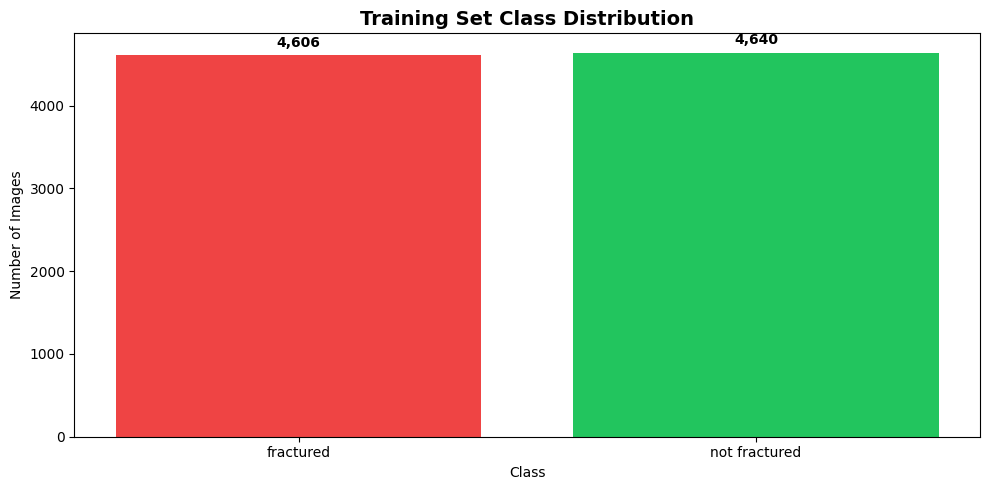

In [8]:
# Class distribution
class_counts = {}
for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_path = TRAIN_DIR / cls
    if cls_path.is_dir():
        class_counts[cls] = len(os.listdir(cls_path))

print("Training set class distribution:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count:,} images")

# Plot distribution
plt.figure(figsize=(10, 5))
classes = list(class_counts.keys())
counts = list(class_counts.values())
colors = ['#ef4444', '#22c55e']
bars = plt.bar(classes, counts, color=colors)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Images')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

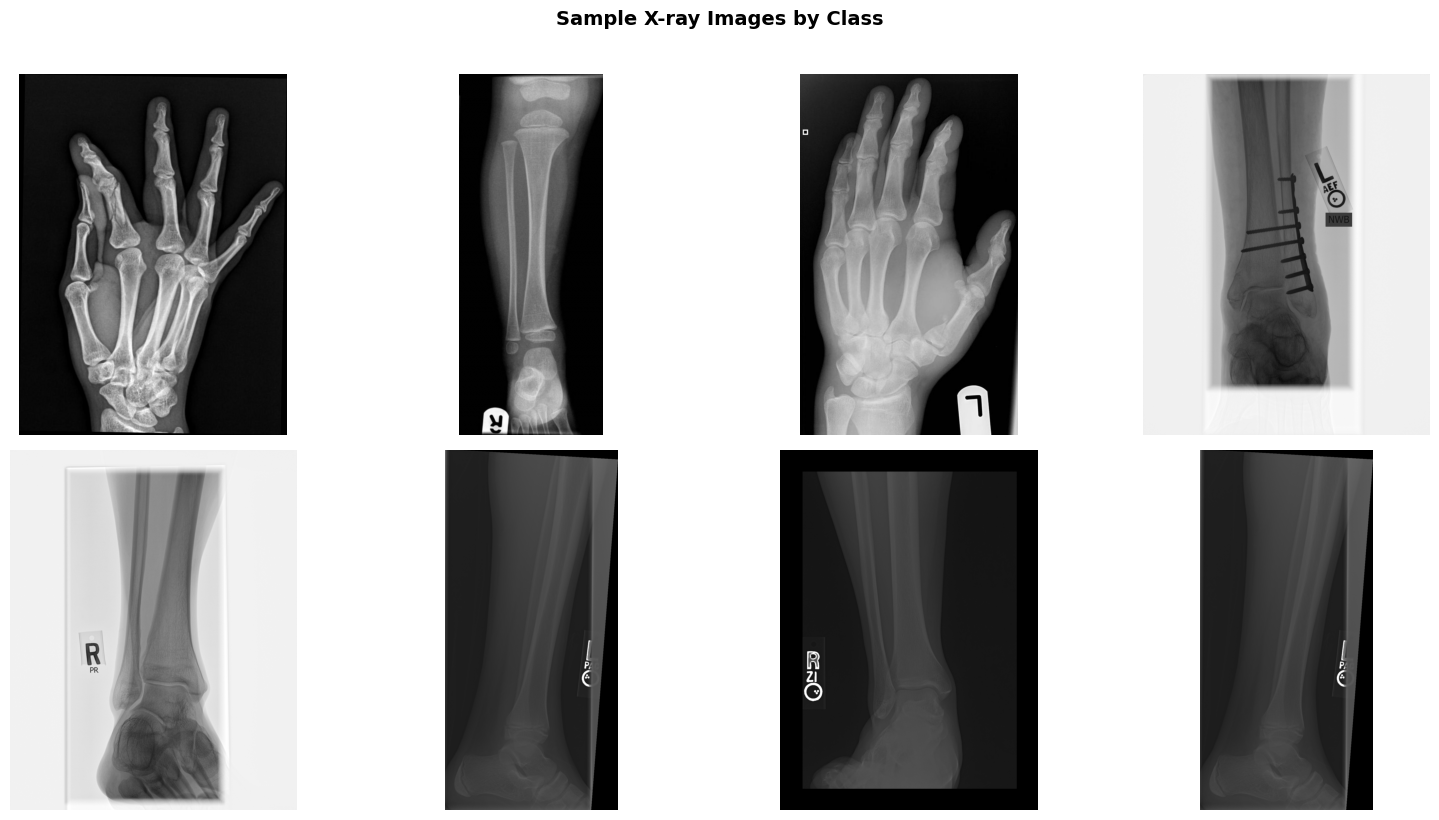

In [9]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
class_names_display = ['Fractured', 'Not Fractured']
class_folders = ['fractured', 'not fractured']

for idx, (cls_folder, cls_name) in enumerate(zip(class_folders, class_names_display)):
    cls_path = TRAIN_DIR / cls_folder
    images = sorted([f for f in cls_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])[:4]

    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        ax = axes[idx, i]
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        if i == 0:
            ax.set_ylabel(cls_name, fontsize=12, fontweight='bold')
        ax.axis('off')

plt.suptitle('Sample X-ray Images by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Data Preparation

In [10]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_CLASSES = 2
CLASS_NAMES = ['fractured', 'not fractured']

In [19]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [20]:
# Fix for truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transform)

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"\nClass mapping: {train_dataset.class_to_idx}")

Training samples: 9,246
Validation samples: 829
Test samples: 506

Class mapping: {'fractured': 0, 'not fractured': 1}


In [22]:
# Handle class imbalance with weighted sampling
targets = train_dataset.targets
class_counts_tensor = Counter(targets)
total_samples = len(targets)

# Calculate weights for each class
class_weights = {cls: total_samples / count for cls, count in class_counts_tensor.items()}
sample_weights = [class_weights[label] for label in targets]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("Class weights for balanced sampling:")
for cls_idx in sorted(class_weights.keys()):
    cls_name = CLASS_NAMES[cls_idx]
    print(f"  {cls_name}: {class_weights[cls_idx]:.3f}")

Class weights for balanced sampling:
  fractured: 2.007
  not fractured: 1.993


In [23]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Training batches: {len(train_loader):,}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 289
Validation batches: 26
Test batches: 16


## 5. Model Architecture

In [24]:
def create_model(num_classes, pretrained=True):
    """Create EfficientNet-V2-S model with custom classifier."""
    # Load pretrained EfficientNet-V2-S
    weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.efficientnet_v2_s(weights=weights)

    # Freeze early layers (keep last few trainable for fine-tuning)
    for param in list(model.parameters())[:-50]:
        param.requires_grad = False

    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.15),
        nn.Linear(512, num_classes)
    )

    return model

# Create model
model = create_model(NUM_CLASSES)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Total parameters: 20,834,386
Trainable parameters: 4,496,130
Frozen parameters: 16,338,256


## 6. Training Setup

In [25]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

# Training configuration
NUM_EPOCHS = 15
PATIENCE = 5  # Early stopping patience

In [26]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## 7. Training Loop

In [27]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

print(f"Training on {len(train_dataset):,} images for {NUM_EPOCHS} epochs...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update scheduler
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc*100:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

print("\n" + "=" * 60)
print(f"Training complete! Best validation accuracy: {best_val_acc*100:.2f}%")

Training on 9,246 images for 15 epochs...

Epoch 1/15
Learning rate: 1.00e-04


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3700 | Train Acc: 82.79%
Val Loss: 1281.2263 | Val Acc: 92.76%
✓ New best model saved! (Val Acc: 92.76%)

Epoch 2/15
Learning rate: 9.89e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1643 | Train Acc: 93.45%
Val Loss: 4592.0681 | Val Acc: 93.73%
✓ New best model saved! (Val Acc: 93.73%)

Epoch 3/15
Learning rate: 9.57e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1088 | Train Acc: 95.85%
Val Loss: 597.1643 | Val Acc: 95.42%
✓ New best model saved! (Val Acc: 95.42%)

Epoch 4/15
Learning rate: 9.05e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0876 | Train Acc: 96.61%
Val Loss: 480.2969 | Val Acc: 96.38%
✓ New best model saved! (Val Acc: 96.38%)

Epoch 5/15
Learning rate: 8.36e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0676 | Train Acc: 97.48%
Val Loss: 339.1959 | Val Acc: 97.47%
✓ New best model saved! (Val Acc: 97.47%)

Epoch 6/15
Learning rate: 7.52e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0574 | Train Acc: 97.96%
Val Loss: 804.6832 | Val Acc: 97.10%
No improvement. Patience: 1/5

Epoch 7/15
Learning rate: 6.58e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
 ^  ^ ^  ^^ ^^^^

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0528 | Train Acc: 97.98%
Val Loss: 0.0565 | Val Acc: 98.07%
✓ New best model saved! (Val Acc: 98.07%)

Epoch 8/15
Learning rate: 5.57e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0416 | Train Acc: 98.37%
Val Loss: 338.3548 | Val Acc: 97.59%
No improvement. Patience: 1/5

Epoch 9/15
Learning rate: 4.53e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0359 | Train Acc: 98.66%
Val Loss: 0.0500 | Val Acc: 98.31%
✓ New best model saved! (Val Acc: 98.31%)

Epoch 10/15
Learning rate: 3.52e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0398 | Train Acc: 98.59%
Val Loss: 24.7078 | Val Acc: 98.07%
No improvement. Patience: 1/5

Epoch 11/15
Learning rate: 2.58e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0326 | Train Acc: 98.85%
Val Loss: 176.8233 | Val Acc: 98.43%
✓ New best model saved! (Val Acc: 98.43%)

Epoch 12/15
Learning rate: 1.74e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0321 | Train Acc: 98.96%
Val Loss: 144.7179 | Val Acc: 98.07%
No improvement. Patience: 1/5

Epoch 13/15
Learning rate: 1.05e-05


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>^^

AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e0ccffccd60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0288 | Train Acc: 98.95%
Val Loss: 1512.8749 | Val Acc: 97.83%
No improvement. Patience: 2/5

Epoch 14/15
Learning rate: 5.28e-06


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0311 | Train Acc: 98.95%
Val Loss: 0.0456 | Val Acc: 98.31%
No improvement. Patience: 3/5

Epoch 15/15
Learning rate: 2.08e-06


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0344 | Train Acc: 98.68%
Val Loss: 1064.6229 | Val Acc: 97.83%
No improvement. Patience: 4/5

Training complete! Best validation accuracy: 98.43%


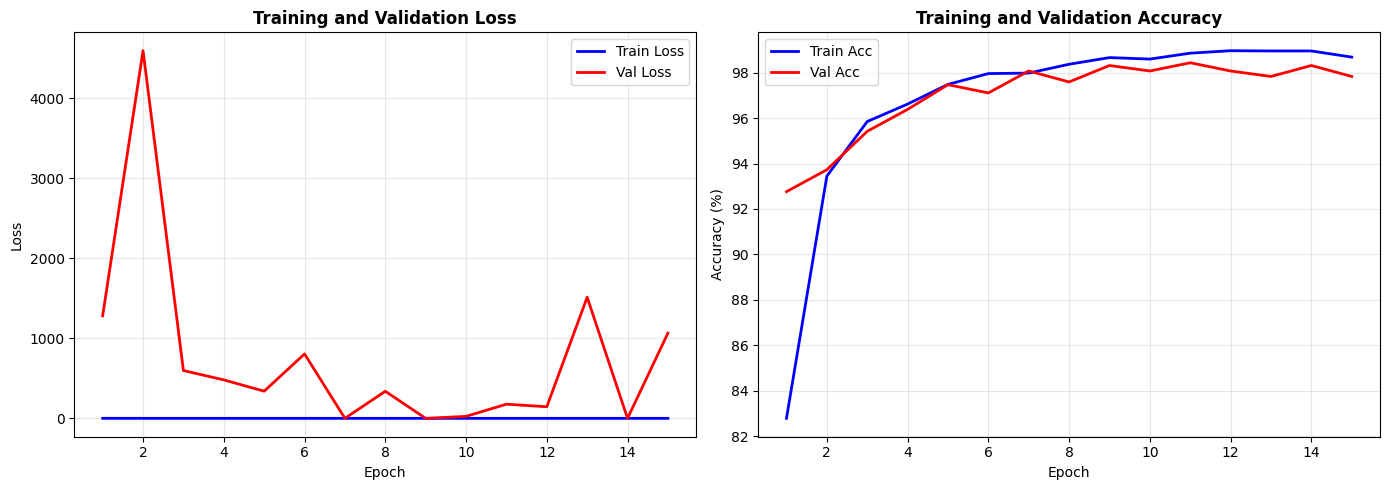

In [28]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, [a*100 for a in history['train_acc']], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, [a*100 for a in history['val_acc']], 'r-', label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bone_fracture_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Evaluation

In [29]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate accuracy
test_acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Test Accuracy: 98.22%


In [30]:
# Classification report
print("\nClassification Report:")
print("=" * 60)
display_names = ['Fractured', 'Not Fractured']
print(classification_report(all_labels, all_preds, target_names=display_names, digits=4))


Classification Report:
               precision    recall  f1-score   support

    Fractured     0.9751    0.9874    0.9812       238
Not Fractured     0.9887    0.9776    0.9831       268

     accuracy                         0.9822       506
    macro avg     0.9819    0.9825    0.9822       506
 weighted avg     0.9823    0.9822    0.9822       506



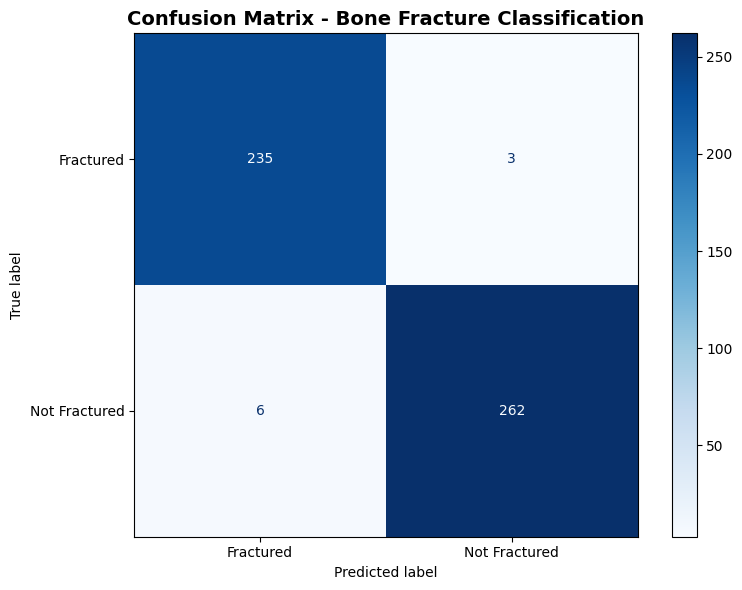


Per-class accuracy:
  Fractured: 98.74%
  Not Fractured: 97.76%


In [31]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Bone Fracture Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('bone_fracture_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\nPer-class accuracy:")
for i, cls in enumerate(display_names):
    cls_acc = cm[i, i] / cm[i].sum()
    print(f"  {cls}: {cls_acc*100:.2f}%")

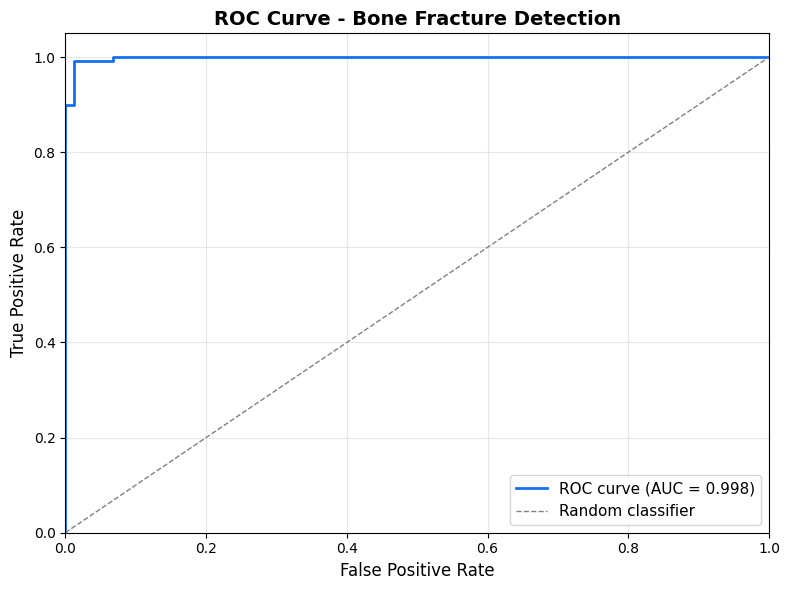


AUC Score: 0.9983


In [32]:
# ROC Curve (for binary classification)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#1570EF', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Bone Fracture Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bone_fracture_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")

## 9. Grad-CAM Visualization

In [33]:
import cv2

class GradCAM:
    """Grad-CAM visualization for EfficientNet."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Generate heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # Resize to input size
        cam = torch.nn.functional.interpolate(
            cam, size=(224, 224), mode='bilinear', align_corners=False
        )

        return cam.squeeze().cpu().numpy(), target_class


def apply_colormap(heatmap, colormap=cv2.COLORMAP_JET):
    """Apply colormap to heatmap."""
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    colored = cv2.applyColorMap(heatmap_uint8, colormap)
    return cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)


def create_overlay(image, heatmap, alpha=0.5):
    """Overlay heatmap on image."""
    colored_heatmap = apply_colormap(heatmap)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    overlay = (alpha * colored_heatmap + (1 - alpha) * image).astype(np.uint8)
    return overlay

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


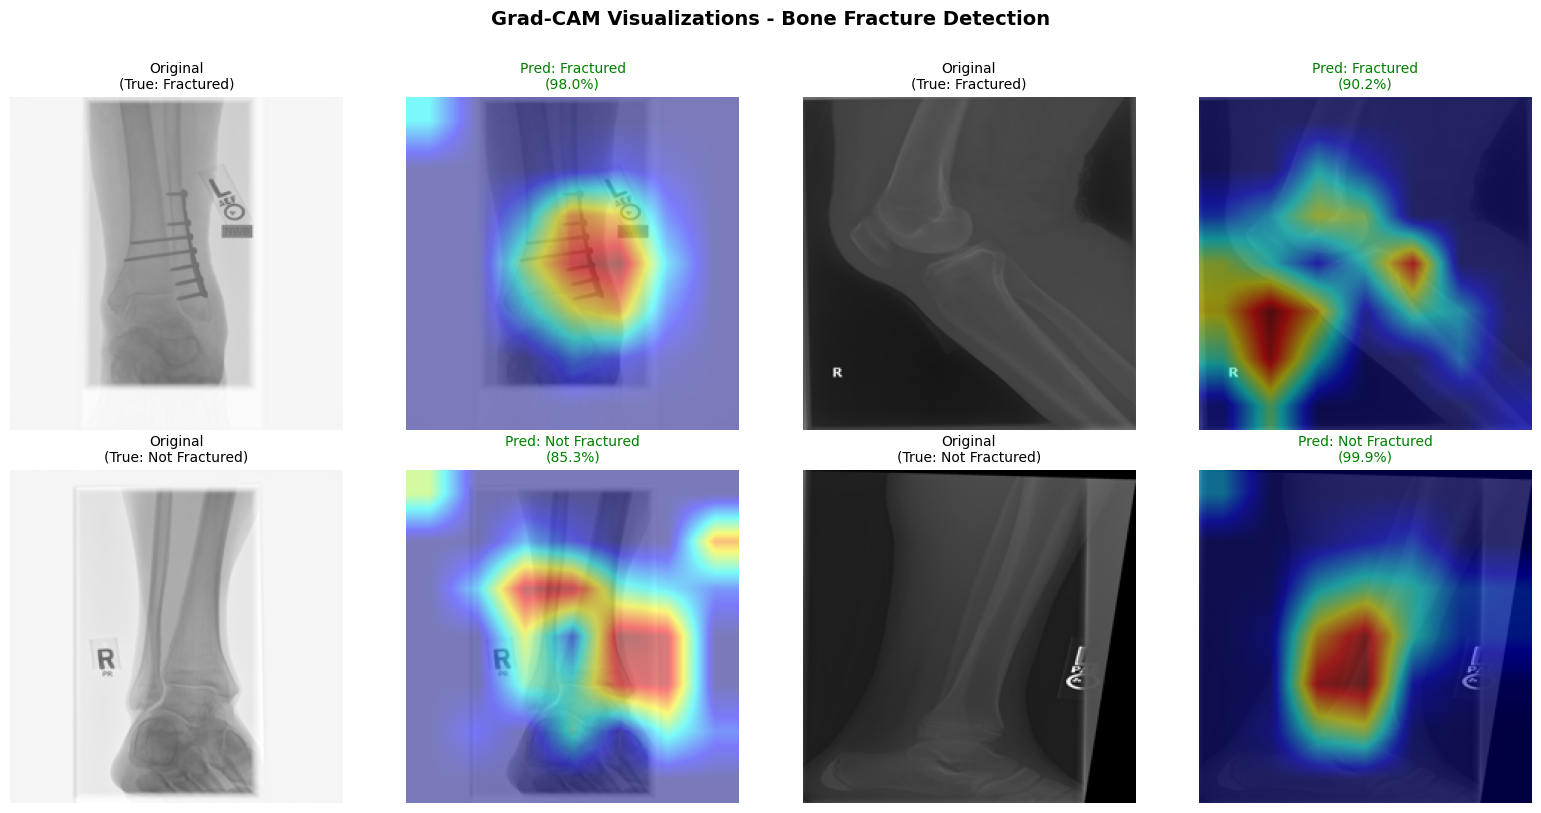

In [34]:
# Initialize Grad-CAM with the last convolutional layer
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

# Get sample images from each class in test set
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
class_folders = ['fractured', 'not fractured']

for cls_idx, cls_folder in enumerate(class_folders):
    # Find images from this class
    cls_path = TEST_DIR / cls_folder
    img_paths = sorted([f for f in cls_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])[:2]

    for img_idx, img_path in enumerate(img_paths):
        row = cls_idx
        col = img_idx * 2

        # Load and preprocess
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_transform(img).unsqueeze(0).to(device)

        # Generate Grad-CAM
        heatmap, pred_class = gradcam.generate(img_tensor)

        # Get prediction probabilities
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)[0]
            confidence = probs[pred_class].item()

        # Prepare images for display
        img_np = np.array(img.resize((224, 224)))
        overlay = create_overlay(img_np, heatmap, alpha=0.5)

        # Get display names
        true_name = 'Fractured' if cls_idx == 0 else 'Not Fractured'
        pred_name = 'Fractured' if pred_class == 0 else 'Not Fractured'

        # Plot original
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(f'Original\n(True: {true_name})', fontsize=10)
        axes[row, col].axis('off')

        # Plot overlay
        color = 'green' if pred_name == true_name else 'red'
        axes[row, col + 1].imshow(overlay)
        axes[row, col + 1].set_title(f'Pred: {pred_name}\n({confidence*100:.1f}%)',
                                      fontsize=10, color=color)
        axes[row, col + 1].axis('off')

plt.suptitle('Grad-CAM Visualizations - Bone Fracture Detection',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('bone_fracture_gradcam.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Export Model for Deployment

In [35]:
# Create deployment directory
!mkdir -p deployment

# Save model weights
model.load_state_dict(torch.load('best_model.pth'))
torch.save(model.state_dict(), 'deployment/bone_fracture_model.pth')

# Save model config
config = {
    'model_name': 'bone_fracture',
    'architecture': 'efficientnet_v2_s',
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'input_size': IMG_SIZE,
    'normalize': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'test_accuracy': float(test_acc),
    'best_val_accuracy': float(best_val_acc),
    'auc_score': float(roc_auc)
}

with open('deployment/bone_fracture_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model config:")
print(json.dumps(config, indent=2))

Model config:
{
  "model_name": "bone_fracture",
  "architecture": "efficientnet_v2_s",
  "num_classes": 2,
  "class_names": [
    "fractured",
    "not fractured"
  ],
  "input_size": 224,
  "normalize": {
    "mean": [
      0.485,
      0.456,
      0.406
    ],
    "std": [
      0.229,
      0.224,
      0.225
    ]
  },
  "test_accuracy": 0.9822134387351779,
  "best_val_accuracy": 0.9843184559710495,
  "auc_score": 0.9983224633136837
}


In [36]:
# Copy visualization assets
!cp bone_fracture_training.png deployment/
!cp bone_fracture_confusion_matrix.png deployment/
!cp bone_fracture_roc_curve.png deployment/
!cp bone_fracture_gradcam.png deployment/

# Create deployment zip
!cd deployment && zip -r ../bone_fracture_deployment.zip .

print("\nDeployment package contents:")
!ls -la deployment/

  adding: bone_fracture_config.json (deflated 45%)
  adding: bone_fracture_training.png (deflated 12%)
  adding: bone_fracture_gradcam.png (deflated 1%)
  adding: bone_fracture_model.pth (deflated 7%)
  adding: bone_fracture_roc_curve.png (deflated 16%)
  adding: bone_fracture_confusion_matrix.png (deflated 21%)

Deployment package contents:
total 83180
drwxr-xr-x 2 root root     4096 Jan 31 20:11 .
drwxr-xr-x 1 root root     4096 Jan 31 20:11 ..
-rw-r--r-- 1 root root      431 Jan 31 20:11 bone_fracture_config.json
-rw-r--r-- 1 root root    42419 Jan 31 20:11 bone_fracture_confusion_matrix.png
-rw-r--r-- 1 root root   712006 Jan 31 20:11 bone_fracture_gradcam.png
-rw-r--r-- 1 root root 84247143 Jan 31 20:11 bone_fracture_model.pth
-rw-r--r-- 1 root root    64349 Jan 31 20:11 bone_fracture_roc_curve.png
-rw-r--r-- 1 root root    89773 Jan 31 20:11 bone_fracture_training.png


In [37]:
# Download deployment package
from google.colab import files
files.download('bone_fracture_deployment.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

### Results
- **Model**: EfficientNet-V2-S
- **Task**: Binary Bone Fracture Classification
- **Classes**: Fractured, Not Fractured
- **Dataset**: 10,580 X-ray images (multi-region)
- **Test Accuracy**: Check output above
- **AUC Score**: Check output above

### Deployment Files
- `bone_fracture_model.pth` - Model weights
- `bone_fracture_config.json` - Model configuration
- `bone_fracture_training.png` - Training curves
- `bone_fracture_confusion_matrix.png` - Confusion matrix
- `bone_fracture_roc_curve.png` - ROC curve
- `bone_fracture_gradcam.png` - Grad-CAM visualizations

